<a href="https://colab.research.google.com/github/Melly567/Cart-Abandonment-/blob/main/EmotionDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torchvision.datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
import os
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [ ]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Step 1: Upload kaggle.json
from google.colab import files
files.upload()  # Upload kaggle.json

# Step 2: Set up Kaggle API
import os
os.makedirs("/root/.kaggle", exist_ok=True)
!cp kaggle.json /root/.kaggle/
os.chmod("/root/.kaggle/kaggle.json", 600)

# Step 3: Install Kaggle CLI
!pip install -q kaggle

# Step 4: Download the public FER2013 dataset
dataset_path = "data"
os.makedirs(dataset_path, exist_ok=True)
!rm -rf data/fer2013  # Remove any corrupted extract
!kaggle datasets download -d msambare/fer2013 -p data

# Step 5: Unzip the dataset
import zipfile

zip_file = os.path.join(dataset_path, "fer2013.zip")
if os.path.exists(zip_file):
    with zipfile.ZipFile(zip_file, "r") as zip_ref:
        print("Unzipping file...")
        zip_ref.extractall(os.path.join(dataset_path, "fer2013"))
        print("Files successfully extracted!")
    os.remove(zip_file)
else:
    raise FileNotFoundError("ZIP file not found after download.")



Saving kaggle.json to kaggle (3).json
Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
  0% 0.00/60.3M [00:00<?, ?B/s]
100% 60.3M/60.3M [00:00<00:00, 1.33GB/s]
Unzipping file...
Files successfully extracted!


In [ ]:
import os

# Explore all contents of the extraction directory
base_dir = "data/fer2013"
for root, dirs, files in os.walk(base_dir):
    print("📁 Directory:", root)
    for f in files:
        print("  └──", f)


📁 Directory: data/fer2013
📁 Directory: data/fer2013/test
📁 Directory: data/fer2013/test/fear
  └── PublicTest_87155807.jpg
  └── PrivateTest_98566325.jpg
  └── PublicTest_99053302.jpg
  └── PublicTest_20185613.jpg
  └── PrivateTest_91810341.jpg
  └── PrivateTest_11661249.jpg
  └── PublicTest_81993157.jpg
  └── PrivateTest_86063456.jpg
  └── PublicTest_7503003.jpg
  └── PublicTest_40423206.jpg
  └── PrivateTest_36687085.jpg
  └── PublicTest_60377876.jpg
  └── PublicTest_13434826.jpg
  └── PublicTest_22444560.jpg
  └── PrivateTest_64589477.jpg
  └── PublicTest_2725530.jpg
  └── PublicTest_41415927.jpg
  └── PublicTest_86202557.jpg
  └── PrivateTest_83921799.jpg
  └── PrivateTest_74791833.jpg
  └── PublicTest_66312779.jpg
  └── PublicTest_99801821.jpg
  └── PrivateTest_7261364.jpg
  └── PrivateTest_13889101.jpg
  └── PrivateTest_65073588.jpg
  └── PrivateTest_33827821.jpg
  └── PublicTest_77017947.jpg
  └── PublicTest_44296746.jpg
  └── PrivateTest_51829395.jpg
  └── PrivateTest_24828491.

In [ ]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transforms
transform = transforms.Compose([
    # transforms.Grayscale(),  # Ensure 1-channel input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_transforms = transforms.Compose([
    # transforms.Grayscale(),
    transforms.RandomResizedCrop(48, scale=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Set dataset directories
train_dir = "data/fer2013/train"
test_dir = "data/fer2013/test"

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Optional: create validation set from training
from torch.utils.data import random_split
val_size = int(0.1 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ✅ Check loaded sizes
print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Train samples: 25839
Validation samples: 2870
Test samples: 7178


In [ ]:
class_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

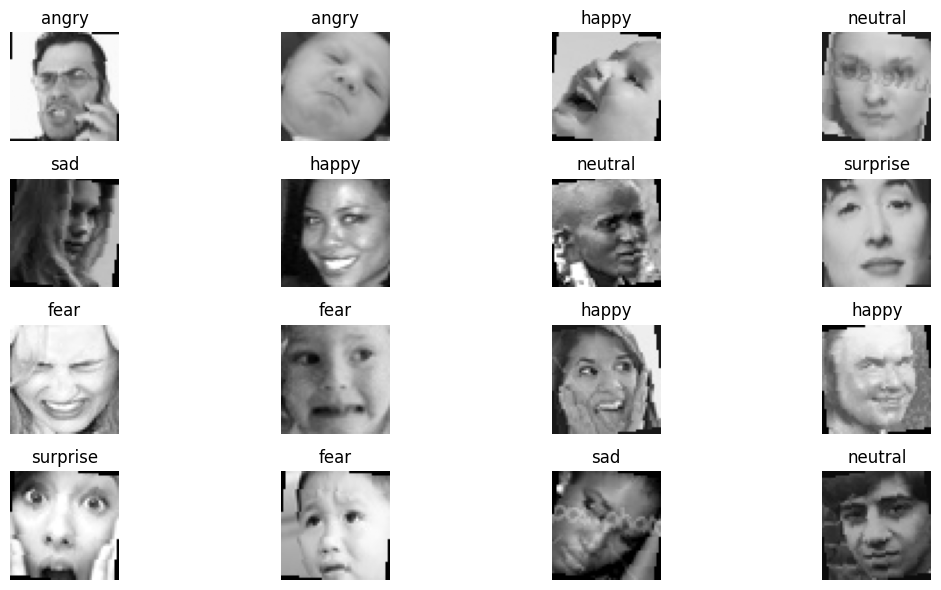

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow_with_labels(images, labels, class_names, n=16):
    # Unnormalize images
    images = images[:n] * 0.5 + 0.5  # reverse normalization
    images = images.numpy()

    plt.figure(figsize=(12, 6))
    for i in range(n):
        plt.subplot(4, 4, i+1)  # 4x4 grid
        img = images[i].transpose((1, 2, 0)).squeeze()  # (H, W, C), squeeze channel for grayscale
        plt.imshow(img, cmap='gray')
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Get a batch from train_loader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show 16 images with their labels
imshow_with_labels(images, labels, train_dataset.dataset.classes, n=16)


In [ ]:
# # Turn images to dataloaders
# from torch.utils.data import DataLoader

# train_dataloader = DataLoader(
#     dataset=train_dataset,
#     batch_size=32,
#     shuffle=True
# )

# val_dataloader = DataLoader(
#     dataset=val_dataset,
#     batch_size=32,
#     shuffle=False
# )

# test_dataloader = DataLoader(
#     dataset=test_dataset,
#     batch_size=32,
#     shuffle=False
# )
# print(f"Train batches: {len(train_loader)}")
# print(f"Validation batches: {len(val_loader)}")
# print(f"Test batches: {len(test_loader)}")


Train batches: 808
Validation batches: 90
Test batches: 225


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EmotionCNN(nn.Module):
    def __init__(self, num_classes=7):  # Adjust `num_classes` as needed
        super(EmotionCNN, self).__init__()

        # Conv Block 1
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.MaxPool2d(2)
        )

        # Conv Block 2
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.MaxPool2d(2)
        )

        # Conv Block 3
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.MaxPool2d(2)
        )

        # Conv Block 4
        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.MaxPool2d(2)
        )

        # Adaptive Pool + Classifier
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.block1(x)  # [B, 64, H/2, W/2]
        x = self.block2(x)  # [B, 128, H/4, W/4]
        x = self.block3(x)  # [B, 256, H/8, W/8]
        x = self.block4(x)  # [B, 512, H/16, W/16]

        x = self.adaptive_pool(x)  # [B, 512, 1, 1]
        x = x.view(x.size(0), -1)  # [B, 512]
        return self.classifier(x)
model = EmotionCNN(num_classes=7)

In [ ]:
import torch.optim as optim

criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 50

for epoch in range(num_epochs):
    model.train()  # set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()           # zero gradients
        outputs = model(images)         # forward pass
        loss = criterion(outputs, labels)  # compute loss
        loss.backward()                 # backpropagation
        optimizer.step()                # update weights

        running_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / total
    train_acc = 100 * correct / total

    # Validation loop
    model.eval()  # set model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= val_total
    val_acc = 100 * val_correct / val_total

    # Step scheduler
    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


Epoch [1/50] Train Loss: 1.7338, Train Acc: 33.97% Val Loss: 1.6782, Val Acc: 38.89%
Epoch [2/50] Train Loss: 1.5581, Train Acc: 44.09% Val Loss: 1.5692, Val Acc: 43.17%
Epoch [3/50] Train Loss: 1.4796, Train Acc: 48.68% Val Loss: 1.5700, Val Acc: 40.56%
Epoch [4/50] Train Loss: 1.4402, Train Acc: 50.50% Val Loss: 1.5312, Val Acc: 45.44%
Epoch [5/50] Train Loss: 1.4061, Train Acc: 52.74% Val Loss: 1.4646, Val Acc: 49.48%
Epoch [6/50] Train Loss: 1.3505, Train Acc: 55.31% Val Loss: 1.4229, Val Acc: 54.01%
Epoch [7/50] Train Loss: 1.3278, Train Acc: 56.79% Val Loss: 1.4114, Val Acc: 54.36%
Epoch [8/50] Train Loss: 1.3111, Train Acc: 57.68% Val Loss: 1.4014, Val Acc: 53.38%
Epoch [9/50] Train Loss: 1.2966, Train Acc: 58.60% Val Loss: 1.3657, Val Acc: 55.26%
Epoch [10/50] Train Loss: 1.2866, Train Acc: 58.75% Val Loss: 1.3940, Val Acc: 54.43%
Epoch [11/50] Train Loss: 1.2511, Train Acc: 60.92% Val Loss: 1.3728, Val Acc: 55.12%
Epoch [12/50] Train Loss: 1.2410, Train Acc: 61.30% Val Loss: 1

In [ ]:
# weights = torchvision.models.MobileNet_V2_Weights.DEFAULT
# auto_transform = weights.transforms()
# model_1 = torchvision.models.mobilenet_v2(weights).to(device)


In [ ]:
# manual_transforms = transforms.Compose([
#     transforms.Resize(232, interpolation=InterpolationMode.BILINEAR),
#     transforms.CenterCrop(224),
#     transforms.Grayscale(num_output_channels=3),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225])
# ])

In [ ]:
# first_conv_layer = [nn.Conv2d(1, 3, kernel_size=3, stride=1, padding=1, dilation=1, groups=1, bias=True)]
# first_conv_layer.extend(list(model_1.features))
# model_1.features= nn.Sequential(*first_conv_layer ).to(device)

In [ ]:
# train_data = torchvision.datasets.FER2013(
#     root="data",
#     split="train",
#     transform=manual_transforms
# )

# test_data = torchvision.datasets.FER2013(
#     root="data",
#     split="test",
#     transform=manual_transforms
# )


# train_dataloader = DataLoader(
#     dataset=train_data,
#     batch_size=32,
#     shuffle=True
# )

# test_dataloader = DataLoader(
#     dataset=test_data,
#     batch_size=32,
#     shuffle=False
# )
# len(train_dataloader), len(test_dataloader)

In [ ]:
# for param in model_1.features.parameters():
#   param.requires_grad=False

In [ ]:
# torch.manual_seed(42)
# torch.cuda.manual_seed(42)

# model_1.classifier = nn.Sequential(
#     nn.Dropout(p=0.2, inplace=True),
#     nn.Linear(
#         in_features=1280,
#         out_features=len(class_names),
#         bias=True
#     )
# ).to(device)

In [ ]:
# model_1

In [ ]:
# # setup loss and optimizer
# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model_1.parameters(), lr=1e-3)

In [ ]:
# # setup accuracy
# def accuracy_fn(y_true, y_pred):
#   correct = torch.eq(y_true, y_pred).sum().item()
#   acc = (correct/len(y_true)) * 100
#   return acc

In [ ]:
# # train model
# epochs=30

# for epoch in range(epochs):
#   for batch, (X,y) in enumerate(train_dataloader):
#     X, y = X.to(device), y.to(device)
#     model_1.train()

#     y_preds = model_1(X)

#     train_loss = loss_fn(y_preds, y)
#     train_acc = accuracy_fn(y, y_preds.argmax(dim=1))

#     optimizer.zero_grad()
#     train_loss.backward()
#     optimizer.step()

#   model_1.eval()
#   with torch.inference_mode():
#     for X, y in test_dataloader:
#       X, y = X.to(device), y.to(device)
#       preds = model_1(X)

#       test_loss = loss_fn(preds, y)

#       test_acc = accuracy_fn(y, preds.argmax(dim=1))
#     print(f"Epoch: {epoch+1}")
#     print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.2f}% | Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%")
